Using the CMSW framework, and the hypothesis that informed traders use limit orders (Bloomfield, O'Hara, Saar (2003)), we test the correlation between the order flow and the price mid. 

We use as reference Rama Cont, Arseniy Kukanov and Sasha Stoikov (March 2011). The price impact of order book events

In [2]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.abspath('../../order_book_simulations'))

from classes.trader import Trader
from classes.order_book import OrderBook

import utilities

from scipy import stats
import statsmodels.api as sm

import statsmodels



In [3]:
def trader_utility_function_expected_value(alpha, wealth_mean, wealth_std):
    # utility function: U(W) = - exp(- alpha * W)
    # where W is trader's wealth
    # the expectation, given that the Wealth is distributed as N(mu_W, sigma_W):
    return - np.exp(- alpha * wealth_mean + ((alpha * wealth_std)**2)/2)

def compute_wealth_mean_base(trader, payoff_mean):
    return trader.number_units_stock_in_inventory * payoff_mean

def compute_wealth_std_base(trader, payoff_std):
    return trader.number_units_stock_in_inventory * payoff_std


def compute_wealth_mean_buy(trader, payoff_mean, price, quantity):
    return (trader.number_units_stock_in_inventory + quantity) * payoff_mean - (price * quantity)

def compute_wealth_std_buy(trader, payoff_std, quantity):
    return (trader.number_units_stock_in_inventory + quantity) * payoff_std

def compute_wealth_mean_sell(trader, payoff_mean, price, quantity):
    return (trader.number_units_stock_in_inventory - quantity) * payoff_mean + (price * quantity)

def compute_wealth_std_sell(trader, payoff_std, quantity):
    return (trader.number_units_stock_in_inventory - quantity) * payoff_std

def probability_hit_buy(price, mean, std): #lambda_par, theta, price):
    #return 1 - np.exp( - lambda_par * (price - theta) )
    z = (price - mean) / std
    
    return stats.norm.cdf(z)


def trader_utility_function_expected_value_hit(
        trader_base_utility_expectation, 
        trader_limit_utility_expectation, 
        probability_hit_limit_order):
    return (
        probability_hit_limit_order * trader_limit_utility_expectation
        ) + (1 - probability_hit_limit_order) * trader_base_utility_expectation


def generate_random_variable_exponential(lambda_, theta):
    U = np.random.uniform(0, 1)
    
    # invert the cdf f(x) = lambda * exp(- lambda * (x - theta))
    X = theta - (1 / lambda_) * np.log(1 - U)
    
    return X

In [4]:
def plot_OFI_vs_mid_price(x, y):
    x = sm.add_constant(x)

    model = sm.OLS(y, x)
    results = model.fit()

    y_pred = results.predict(x)

    plt.scatter(x[:,1], y)
    plt.axhline(0, color='black', linewidth=0.5)
    plt.axvline(0, color='black', linewidth=0.5)
    plt.xlabel('Order Flow Imbalance')
    plt.ylabel('Mid Price diff')


    plt.plot(x[:, 1], y_pred, color='red', label='Linear Regression Line')

    plt.legend()
    plt.show()

    print("Linear regression parameters")
    print(results.params)

In [5]:
np.random.seed(700)


initial_wealth = 5

alpha = 1

ticksize = 0.01

In [6]:
def simulate(book, fraction_of_informed_buyers, prob_seller, simulation_length, payoff_mean, payoff_std, aggregate_time):
    # initial bids and asks to provide some liquidity
    book.bids = [((payoff_mean - ticksize*1), 10, 0, 0), ((payoff_mean - ticksize*2), 12, 0, 0), ((payoff_mean - ticksize*3), 15, 0, 0), ((payoff_mean - ticksize*4), 20, 0, 0)]
    book.asks = [((payoff_mean + ticksize*1), 10, 0, 0), ((payoff_mean + ticksize*2), 12, 0, 0), ((payoff_mean + ticksize*3), 15, 0, 0), ((payoff_mean + ticksize*4), 20, 0, 0)]
    
    for ii in range(simulation_length):

        rand = np.random.uniform(low=0, high=1)
        quantity = abs(np.random.normal(0, 1))

        if rand < prob_seller:
            # the trader is a seller
            trader = Trader(number_units_stock_in_inventory=quantity)
            base_utility = trader_utility_function_expected_value(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, payoff_mean), 
                    wealth_std=compute_wealth_std_base(trader, payoff_std)
                )
        
            best_bid = book.bids[0][0]

            # noisy seller       
            sell_price = round(best_bid + abs(np.random.normal(0, payoff_std)), utilities.number_of_decimal_digits(ticksize))
            
            expected_payoff = sell_price - abs(np.random.normal(0, payoff_std))

            base_utility = trader_utility_function_expected_value(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, expected_payoff), 
                    wealth_std=compute_wealth_std_base(trader, payoff_std)
                )
            
            limit_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_sell(trader, expected_payoff, price=sell_price, quantity=quantity), 
                wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=quantity)
            )

            market_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_sell(trader, expected_payoff, price=best_bid, quantity=quantity), 
                wealth_std=compute_wealth_std_sell(trader, payoff_std, quantity=quantity)
            )

            # sell prob
            probability_hit_limit_order = 1 - probability_hit_buy(price=sell_price, mean=expected_payoff, std=payoff_std)

            hit_utility = trader_utility_function_expected_value_hit(
                trader_base_utility_expectation=base_utility,
                trader_limit_utility_expectation=limit_utility,
                probability_hit_limit_order=probability_hit_limit_order)

            if (hit_utility > market_utility) and (hit_utility > base_utility):
                # limit sell
                trader.submit_order_to_order_book(
                    order_type='limit_sell', 
                    price=sell_price, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            elif (market_utility > base_utility) and (market_utility > hit_utility):
                trader.submit_order_to_order_book(
                    order_type='market_sell', 
                    price=None, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
                
            else:
                trader.submit_order_to_order_book(
                    order_type='do_nothing', 
                    price=None, 
                    quantity=None,
                    book=book,
                    verbose=False)

        
        else:
            # the trader is a buyer
            rand = np.random.uniform(low=0, high=1)
            
            best_ask = book.asks[0][0]

            if rand < fraction_of_informed_buyers:
                # the trader is informed
                # doesn't want to pay more than the payoff
                buy_price = round(min(payoff_mean - abs(np.random.normal(0, payoff_std)), best_ask), utilities.number_of_decimal_digits(ticksize))
                std = 0
                expected_payoff = payoff_mean
            else:
                # noise trader, trades around the final payoff
                buy_price = round(best_ask - abs(np.random.normal(0, payoff_std)), utilities.number_of_decimal_digits(ticksize))
                std = payoff_std
                expected_payoff = buy_price + abs(np.random.normal(0, payoff_std))

            trader = Trader(number_units_stock_in_inventory=0)
            base_utility = trader_utility_function_expected_value(
                    alpha=alpha, 
                    wealth_mean=compute_wealth_mean_base(trader, expected_payoff), 
                    wealth_std=compute_wealth_std_base(trader, std)
                )
            

            limit_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_buy(trader, expected_payoff, price=buy_price, quantity=quantity), 
                wealth_std=compute_wealth_std_buy(trader, std, quantity=quantity)
            )
            
            market_utility = trader_utility_function_expected_value(
                alpha=alpha, 
                wealth_mean=compute_wealth_mean_buy(trader, expected_payoff, price=best_ask, quantity=quantity), 
                wealth_std=compute_wealth_std_buy(trader, std, quantity=quantity)
            )

            probability_hit_limit_order = probability_hit_buy(price=buy_price, mean=expected_payoff, std=payoff_std)

            hit_utility = trader_utility_function_expected_value_hit(
                trader_base_utility_expectation=base_utility,
                trader_limit_utility_expectation=limit_utility,
                probability_hit_limit_order=probability_hit_limit_order
                )

            if (hit_utility > base_utility) and (hit_utility > market_utility):
                # limit order -> it has a prob of execution
                trader.submit_order_to_order_book(
                    order_type='limit_buy', 
                    price=buy_price, 
                    quantity=quantity,
                    book=book,
                    verbose=False)
                
            elif (market_utility > base_utility) and (market_utility > hit_utility):
                # market order -> no prob because it will surely be executed
                trader.submit_order_to_order_book(
                    order_type='market_buy', 
                    price=None,
                    quantity=quantity,
                    book=book,
                    verbose=False)
            
            else:
                trader.submit_order_to_order_book(
                    order_type='do_nothing', 
                    price=None, 
                    quantity=None,
                    book=book,
                    verbose=False)

    def sum_blocks(l, size_block):
        sum_block = []
        for i in range(0, len(l), size_block):
            block = l[i:i + size_block]
            sum_b = sum(block)
            sum_block.append(sum_b)
        return sum_block


    order_flow_imbalance = sum_blocks(book.order_flow_imbalance_sequence, aggregate_time)

    mid_price_diff = [0, ]
    for i in range(1, len(book.mid_price_sequence)):
        change = (book.mid_price_sequence[i] - book.mid_price_sequence[i-1])
        mid_price_diff.append(change)

    mid_price_diff = sum_blocks(mid_price_diff, aggregate_time)

    return book, order_flow_imbalance, mid_price_diff


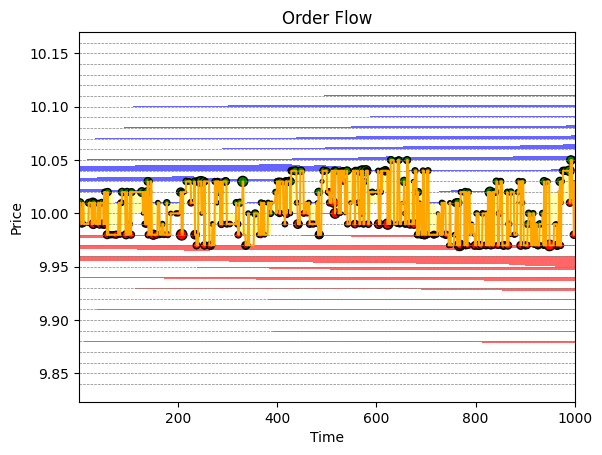

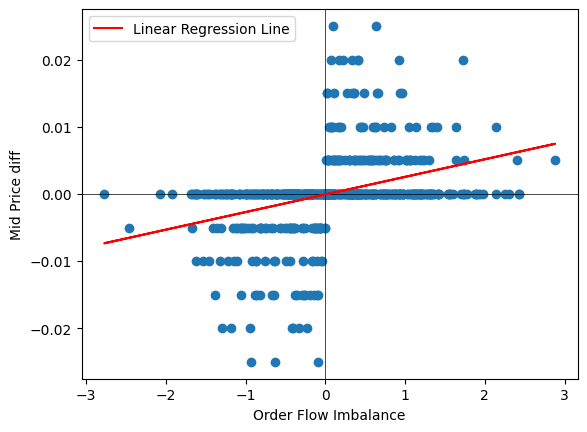

Linear regression parameters
[-8.28925973e-05  2.61900257e-03]


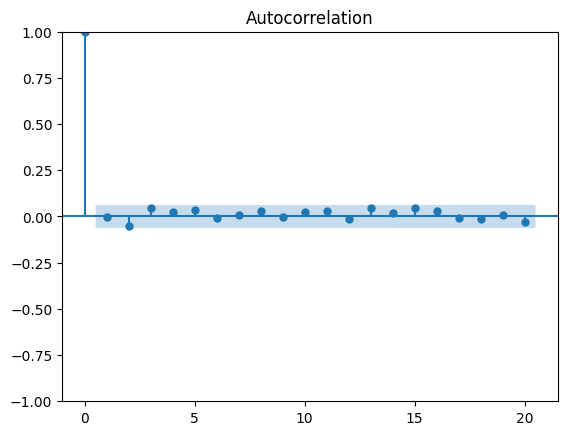

In [7]:
book, order_flow_imbalance, mid_price_diff = simulate(
                book=OrderBook(), 
                fraction_of_informed_buyers=0, 
                prob_seller=0.5, 
                simulation_length=1000, 
                payoff_mean=10, 
                payoff_std=0.05,
                aggregate_time=1)

utilities.plot_order_flow(book.book_state_sequence,
                        price_sequence=book.price_sequence,
                        volumes_sequence=book.volumes_sequence,
                        buy_sequence=book.buy_sequence,
                        sell_sequence=book.sell_sequence,
                        ticksize=ticksize,
                        #y_min=9.8,
                        #y_max=10.2
                        )

plot_OFI_vs_mid_price(order_flow_imbalance, mid_price_diff)

statsmodels.graphics.tsaplots.plot_acf(np.array(order_flow_imbalance).squeeze(), lags=20, alpha=0.05)
plt.show()

In [8]:
book, order_flow_imbalance, mid_price_diff = simulate(
                book=OrderBook(), 
                fraction_of_informed_buyers=0, 
                prob_seller=0.5, 
                simulation_length=1000, 
                payoff_mean=10, 
                payoff_std=0.01,
                aggregate_time=1)

utilities.plot_order_flow(book.book_state_sequence,
                        price_sequence=book.price_sequence,
                        volumes_sequence=book.volumes_sequence,
                        buy_sequence=book.buy_sequence,
                        sell_sequence=book.sell_sequence,
                        ticksize=ticksize,
                        #y_min=9.8,
                        #y_max=10.2
                        )

plot_OFI_vs_mid_price(order_flow_imbalance, mid_price_diff)

statsmodels.graphics.tsaplots.plot_acf(np.array(order_flow_imbalance).squeeze(), lags=20, alpha=0.05)
plt.show()

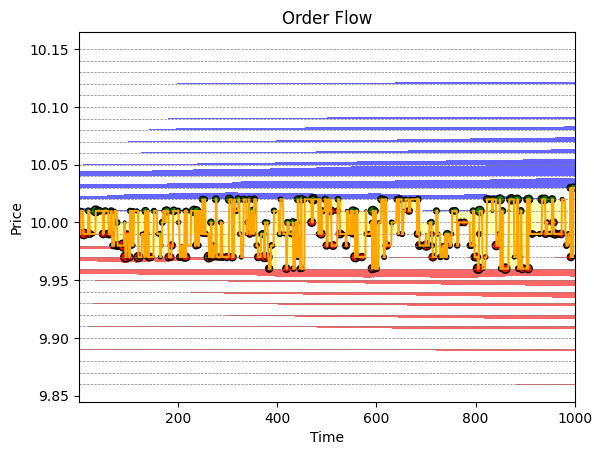

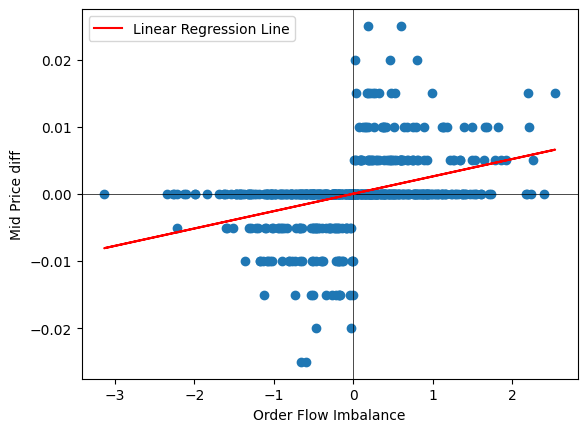

Linear regression parameters
[2.13944415e-05 2.58531616e-03]


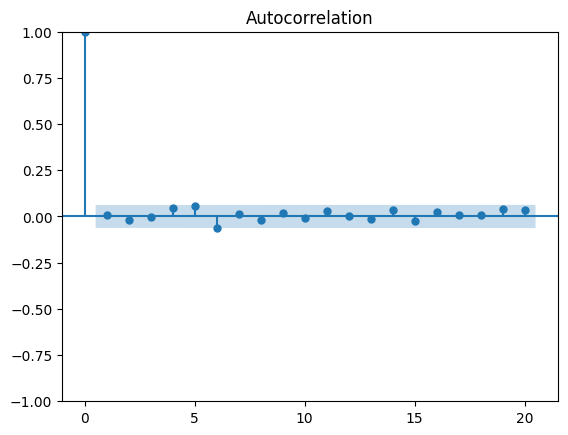

In [ ]:
book, order_flow_imbalance, mid_price_diff = simulate(
                book=OrderBook(), 
                fraction_of_informed_buyers=0.25, 
                prob_seller=0.5, 
                simulation_length=1000, 
                payoff_mean=10, 
                payoff_std=0.05,
                aggregate_time=1)

utilities.plot_order_flow(book.book_state_sequence,
                        price_sequence=book.price_sequence,
                        volumes_sequence=book.volumes_sequence,
                        buy_sequence=book.buy_sequence,
                        sell_sequence=book.sell_sequence,
                        ticksize=ticksize,
                        #y_min=9.8,
                        #y_max=10.2
                        )


plot_OFI_vs_mid_price(order_flow_imbalance, mid_price_diff)

statsmodels.graphics.tsaplots.plot_acf(np.array(order_flow_imbalance).squeeze(), lags=20, alpha=0.05)
plt.show()

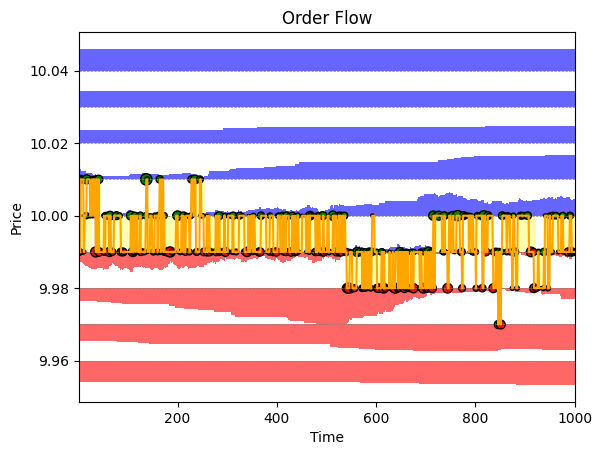

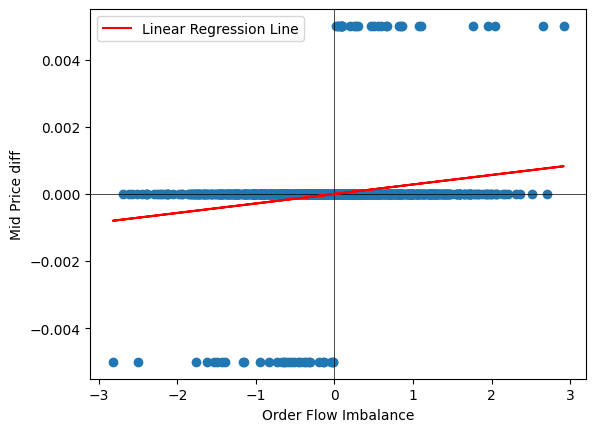

Linear regression parameters
[-1.24693317e-06  2.82772857e-04]


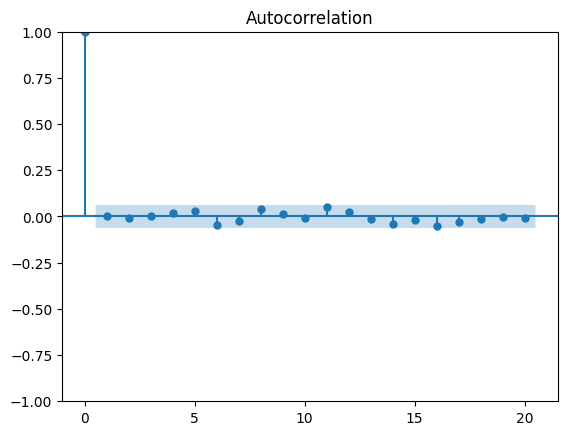

In [ ]:
book, order_flow_imbalance, mid_price_diff = simulate(
                book=OrderBook(), 
                fraction_of_informed_buyers=0.25, 
                prob_seller=0.5, 
                simulation_length=1000, 
                payoff_mean=10, 
                payoff_std=0.01,
                aggregate_time=1)

utilities.plot_order_flow(book.book_state_sequence,
                        price_sequence=book.price_sequence,
                        volumes_sequence=book.volumes_sequence,
                        buy_sequence=book.buy_sequence,
                        sell_sequence=book.sell_sequence,
                        ticksize=ticksize,
                        #y_min=9.8,
                        #y_max=10.2
                        )

plot_OFI_vs_mid_price(order_flow_imbalance, mid_price_diff)

statsmodels.graphics.tsaplots.plot_acf(np.array(order_flow_imbalance).squeeze(), lags=20, alpha=0.05)
plt.show()